In [10]:
import jax.numpy as jnp
import jax
from fbpinns.problems import Problem

class Poisson2D(Problem):
    """
    Solves the 2D Poisson equation
        - u_xx - u_yy = f(x,y)
    on the domain [0,1] with Dirichlet boundary conditions u = 0 on ∂Ω.

    We choose f(x,y) such that the exact solution is:
        u(x,y) = sin(πx)sin(πy)
    which implies f(x,y) = 2π²sin(πx)sin(πy).
    """

    @staticmethod
    def init_params(f_coeff=2 * jnp.pi ** 2, sd=0.1, N=10000):
        # 'dims': (ud, xd) => u is scalar (ud=1) and x is 2D (xd=2)
        static_params = {
            "dims": (1, 2),
            "f_coeff": f_coeff,  # coefficient in the forcing function f(x,y)
            "sd": sd,
            'statictest': 1
        }
        return static_params, {'alpha': jnp.zeros((N, 1))}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):
        # --- Physics loss: sample interior points ---
        # x_batch_phys: an array of shape (n_phys, 2)
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0, (0, 0)), # u_xx
            (0, (1, 1)), # u_yy
        )

        return [[x_batch_phys, required_ujs_phys],]
    
    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, y, tanh = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh
        u = tanh((x)/sd) * tanh((1-x)/sd) * tanh((y)/sd) * tanh((1-y)/sd) * u
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        # --- Physics loss ---
        # For the physics group, the constraints have been replaced with the evaluated quantities:
        # [x_batch_phys, u_xx, u_yy]
        x_phys, u_xx, u_yy = constraints[0]
        jax.debug.print(f'x {x_phys.shape}, uxx {u_xx.shape}, uyy {u_yy.shape}')
        # x (10000, 2) uxx (10000, 1) uyy (10000, 1)
        x, y = x_phys[:, 0:1], x_phys[:,1:2]

        # Compute the forcing term f(x,y) = 2π² sin(πx) sin(πy)
        f_coeff = all_params["static"]["problem"]["f_coeff"]
        f_val = f_coeff * jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)

        # The physics residual is: u_xx + u_yy + f(x,y)
        phys_residual = u_xx + u_yy + f_val
        # RBA weights
        alpha = all_params["trainable"]["problem"]["alpha"]  # (N,1)

        m1 = jnp.mean(phys_residual**2)
        m2 = jnp.mean(((0.01+alpha)*phys_residual)**2)
        jax.debug.print("raw MSE = {m1:.6f}, weighted MSE = {m2:.6f}", m1=m1, m2=m2)
        jax.debug.print("residual max = {a}, alpha head = {b}", a=jnp.max(jnp.abs(phys_residual)), b=alpha[:5, 0])
        
        return jnp.mean(
            # ( (0.01+alpha) * phys_residual ) ** 2
            phys_residual ** 2
            ), phys_residual

    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape=None):
        # The exact solution is u(x,y) = sin(πx) sin(πy)
        x, y = x_batch[:, 0:1], x_batch[:,1:2]
        u = jnp.sin(jnp.pi* x) * jnp.sin(jnp.pi* y)
        return u
    

[INFO] 2025-04-17 18:46:35 - <fbpinns.constants.Constants object at 0x715bc01da870>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.Poisson2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 3.0)}
network: <class 'fbpinns.networks.ChebyshevKAN'>
network_init_kwargs: {'input_dim': 2, 'output_dim': 1, 'degree': 10, 'kind': 1}
n_steps: 10000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((100, 100),)
n_test: (100, 100)
sampler: grid
optimiser: <function adam at 0x715d025efa60>
optimiser_kwargs: {'learning_rate': 0.001}
seed: 0
summary_freq: 1000


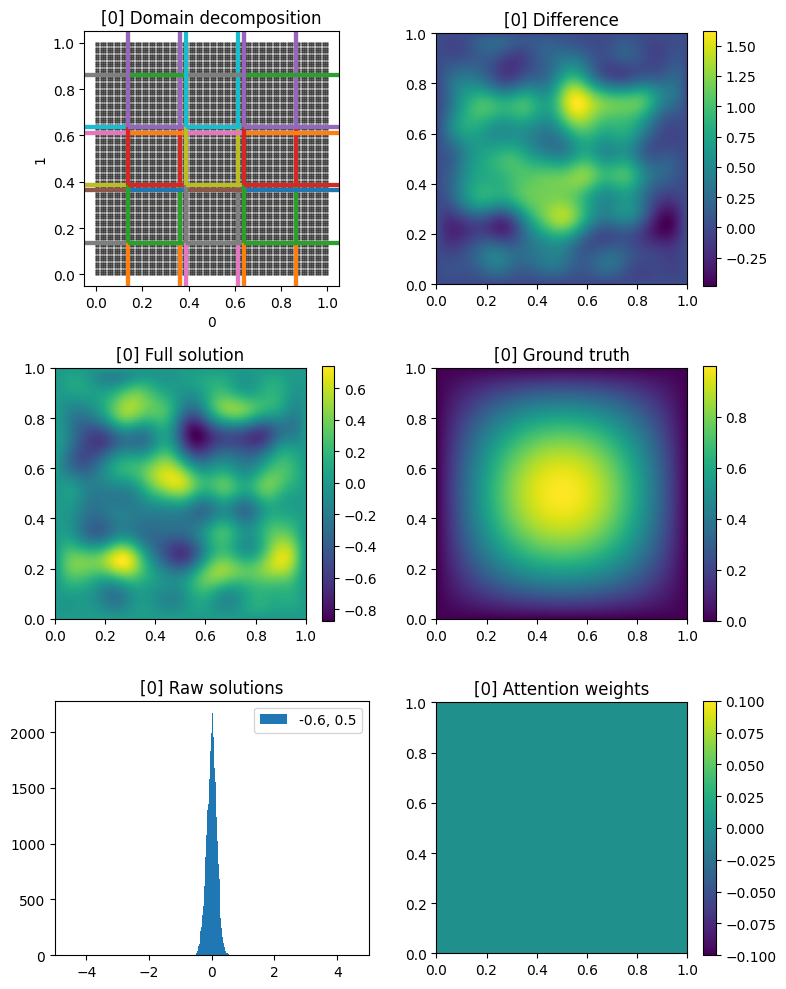

x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 15918.612305, weighted MSE = 1.591861
residual max = 439.54241943359375, alpha head = [0. 0. 0. 0. 0.]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 14790.815430, weighted MSE = 3.334273
residual max = 423.5197448730469, alpha head = [0.         0.0002004  0.00038491 0.00054257 0.00066434]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 13725.849609, weighted MSE = 5.566204
residual max = 407.50714111328125, alpha head = [0.         0.00039981 0.00076763 0.0010814  0.00132289]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 12723.730469, weighted MSE = 8.134442
residual max = 391.5132751464844, alpha head = [0.         0.00059838 0.00114843 0.00161684 0.00197602]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 11783.536133, weighted MSE = 10.909176
residual max = 375.5640563964844, alpha head = [0.         0.00079635 0.00152776 0.00214948 0.0026244 ]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE

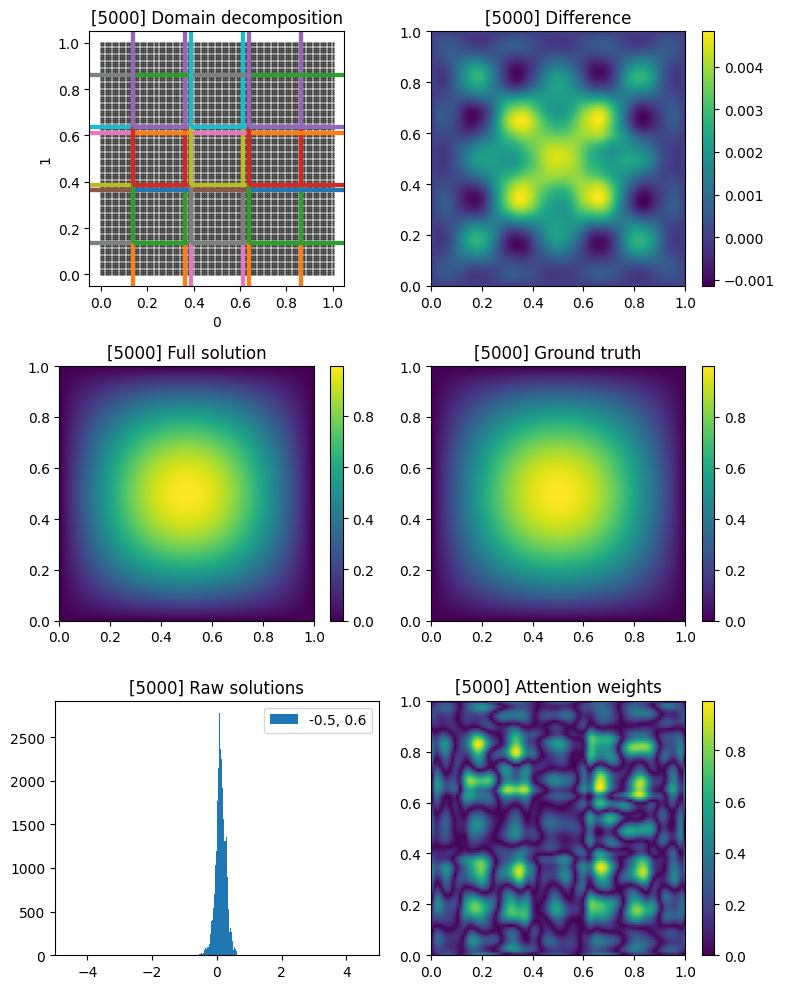

x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 0.345287, weighted MSE = 0.110391
residual max = 1.9291009902954102, alpha head = [0.         0.0341672  0.05872383 0.07476372 0.08250815]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 0.345266, weighted MSE = 0.110353
residual max = 1.9291133880615234, alpha head = [0.         0.03418859 0.05876414 0.07481929 0.08257481]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 0.345244, weighted MSE = 0.110370
residual max = 1.9291296005249023, alpha head = [0.         0.03420996 0.05880442 0.07487483 0.08264143]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 0.345223, weighted MSE = 0.110360
residual max = 1.929173469543457, alpha head = [0.         0.03423129 0.05884465 0.0749303  0.08270796]
x (10000, 2), uxx (10000, 1), uyy (10000, 1)
raw MSE = 0.345202, weighted MSE = 0.110347
residual max = 1.9291715621948242, alpha head = [0.         0.03425261 0.05888484 0.07498573 0.08277445]
x (10000, 2), uxx (10000, 1), u

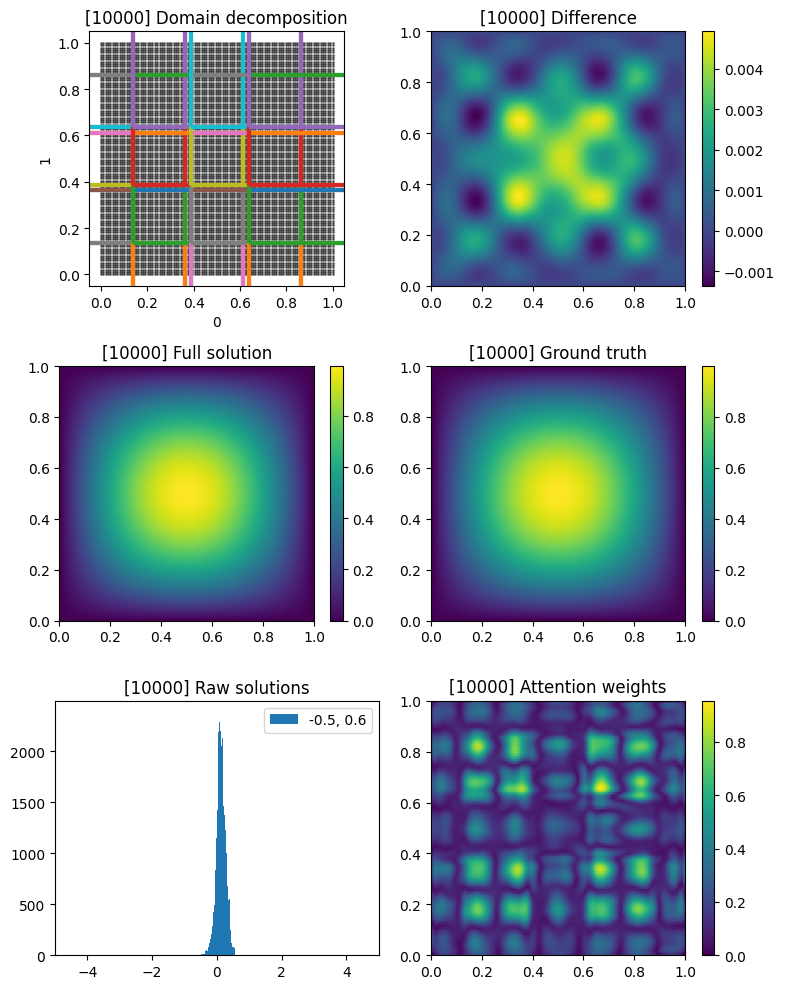

[INFO] 2025-04-17 18:47:01 - [i: 10000/10000] Training complete


In [11]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import ChebyshevKAN, FCN, ChebyshevAdaptiveKAN
from fbpinns.schedulers import LineSchedulerRectangularND, PointSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=Poisson2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0., 3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 10, 1),
    # ),
    # network=ChebyshevAdaptiveKAN,
    network=ChebyshevKAN,
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=10,
        kind=1
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
    ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    # scheduler = PointSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.5, 0.5],\
    # ),
    # First element: interior sampling shape for the physics loss (here 200 x 200 points)
    # Second element: boundary sampling shapes; for 2D, we need 4 tuples (one for each boundary)
    ns=((100, 100),),
    # n_test provides the test sampling shape for the interior (here also 200 x 200)
    n_test=(100, 100),
    n_steps=10000,
    clear_output=False,
)

run = FBPINNTrainer(c)
# run = PINNTrainer(c)
all_params = run.train()

In [12]:
all_params['trainable']['network']['subdomain']['coeffs'].shape

(25, 2, 1, 11)